In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

In [2]:
# 데이터 로딩
df_train = pd.read_csv('C:/Users/wnrrh/desktop/dacon/penguin/train.csv')
df_test = pd.read_csv('C:/Users/wnrrh/desktop/dacon/penguin/test.csv')
ss = pd.read_csv('C:/Users/wnrrh/desktop/dacon/penguin/sample_submission.csv')

In [3]:
# 불필요한 컬럼 제거
df_train.drop(['id'],axis=1, inplace=True)
df_test.drop(['id'],axis=1, inplace=True)

In [4]:
ob_cols = df_train.dtypes[df_train.dtypes == 'object'].index.tolist()
for i in ob_cols:
    print('i:', i)
    print(df_train[i].value_counts(),'\n')

i: Species
Gentoo penguin (Pygoscelis papua)            48
Adelie Penguin (Pygoscelis adeliae)          41
Chinstrap penguin (Pygoscelis antarctica)    25
Name: Species, dtype: int64 

i: Island
Biscoe       57
Dream        44
Torgersen    13
Name: Island, dtype: int64 

i: Clutch Completion
Yes    102
No      12
Name: Clutch Completion, dtype: int64 

i: Sex
MALE      56
FEMALE    55
Name: Sex, dtype: int64 



In [5]:
# 훈련 데이터 내 결측치 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(df_train)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.


In [6]:
# 테스트 데이터 내 결측치 확인
missing_val = check_missing_col(df_test)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 6개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 9개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 8개의 결측치가 존재합니다.


Sex,Clutch Completion 는 male은 1, female은 0, Yes 는 1, No 는 0으로 처리

Island와 Species는 원 핫 인코딩으로 처리

In [7]:
df_train['Sex']=np.where(df_train['Sex'].values=='MALE',1,np.where(df_train['Sex'].values=='FEMALE',0,np.nan))
df_test['Sex']=np.where(df_test['Sex'].values=='MALE',1,np.where(df_test['Sex'].values=='FEMALE',0,np.nan))
df_train['Clutch Completion']=np.where(df_train['Clutch Completion'].values=='Yes',1,0)
df_test['Clutch Completion']=np.where(df_test['Clutch Completion'].values=='Yes',1,0)
train = pd.concat([df_train,pd.get_dummies(df_train[['Island','Species']])],axis=1)
test = pd.concat([df_test,pd.get_dummies(df_test[['Island','Species']])],axis=1)
train = train.drop(['Island','Species'],axis=1)
test = test.drop(['Island','Species'],axis=1)

In [8]:
train

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,1,50.0,15.3,220,1.0,8.30515,-25.19017,5550,1,0,0,0,0,1
1,0,49.5,19.0,200,1.0,9.63074,-24.34684,3800,0,1,0,0,1,0
2,1,45.1,14.4,210,0.0,8.51951,-27.01854,4400,1,0,0,0,0,1
3,1,44.5,14.7,214,0.0,8.20106,-26.16524,4850,1,0,0,0,0,1
4,0,49.6,16.0,225,1.0,8.38324,-26.84272,5700,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1,36.6,17.8,185,0.0,NaN,NaN,3700,0,0,1,1,0,0
110,1,39.2,18.6,190,1.0,9.11006,-25.79549,4250,0,1,0,1,0,0
111,1,43.2,18.5,192,1.0,8.97025,-26.03679,4100,0,1,0,1,0,0
112,0,46.9,16.6,192,0.0,9.80589,-24.73735,2700,0,1,0,0,1,0


# 결측치 채우기

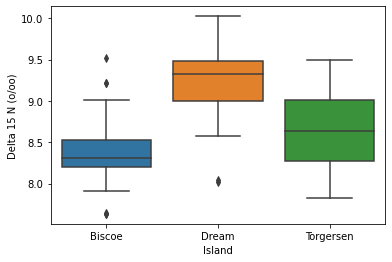

In [9]:
sns.boxplot(x='Island', y='Delta 15 N (o/oo)', data=df_train[['Island','Delta 15 N (o/oo)']])
plt.show()

하지만 종과 섬 별로 Delta 15N 그래프를 그려보니 같은 섬이라도 종별로 차이가 있음

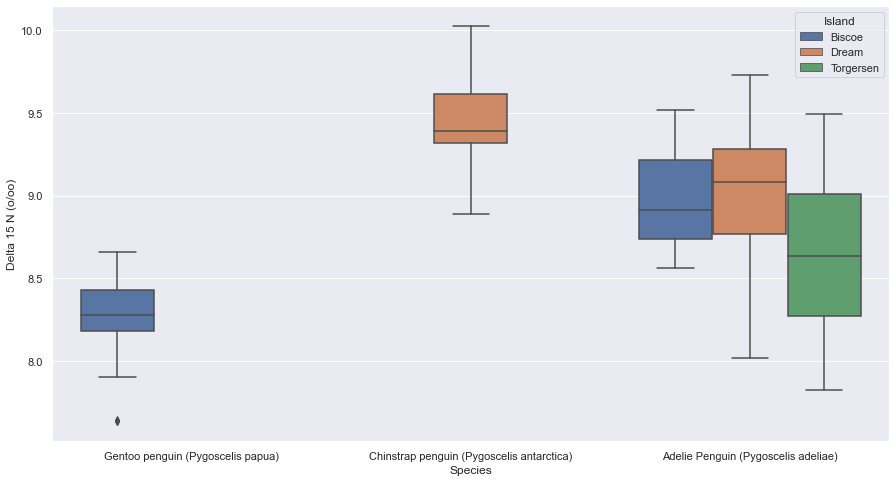

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 15 N (o/oo)',hue = 'Island', data=df_train[['Island','Species','Delta 15 N (o/oo)']])
plt.show()

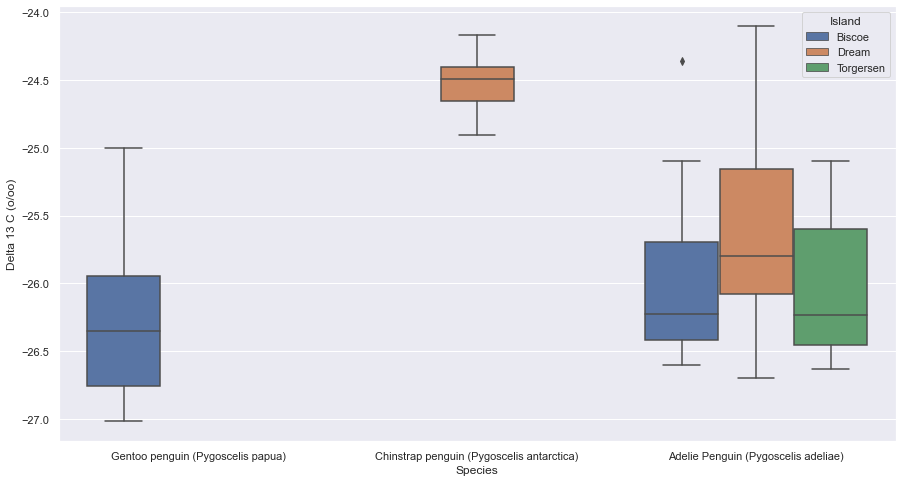

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 13 C (o/oo)',hue = 'Island', data=df_train[['Island','Species','Delta 13 C (o/oo)']])
plt.show()

In [12]:
set_option('precision',2)
train.corr(method='pearson')

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
Clutch Completion,1.00,-0.12,-0.21,0.11,-1.13e-01,-0.28,-0.29,0.09,2.29e-01,-3.15e-01,0.12,0.08,-0.30,0.18
Culmen Length (mm),-0.12,1.00,-0.25,0.67,3.24e-01,-0.04,0.11,0.57,2.97e-01,-4.72e-02,-0.39,-0.82,0.38,0.48
Culmen Depth (mm),-0.21,-0.25,1.00,-0.60,3.69e-01,0.65,0.48,-0.49,-7.25e-01,5.60e-01,0.28,0.52,0.38,-0.83
Flipper Length (mm),0.11,0.67,-0.60,1.00,2.51e-01,-0.53,-0.45,0.86,7.40e-01,-5.66e-01,-0.30,-0.69,-0.25,0.88
Sex,-0.11,0.32,0.37,0.25,1.00e+00,0.14,-0.10,0.42,-9.09e-03,-7.30e-03,0.03,0.05,-0.07,0.01
Delta 15 N (o/oo),-0.28,-0.04,0.65,-0.53,1.36e-01,1.00,0.64,-0.55,-6.44e-01,7.03e-01,-0.07,0.17,0.65,-0.71
Delta 13 C (o/oo),-0.29,0.11,0.48,-0.45,-9.94e-02,0.64,1.00,-0.47,-5.89e-01,6.74e-01,-0.11,-0.09,0.76,-0.56
Body Mass (g),0.09,0.57,-0.49,0.86,4.20e-01,-0.55,-0.47,1.00,7.08e-01,-5.74e-01,-0.24,-0.51,-0.39,0.82
Island_Biscoe,0.23,0.30,-0.72,0.74,-9.09e-03,-0.64,-0.59,0.71,1.00e+00,-7.93e-01,-0.36,-0.42,-0.53,0.85
Island_Dream,-0.32,-0.05,0.56,-0.57,-7.30e-03,0.70,0.67,-0.57,-7.93e-01,1.00e+00,-0.28,0.12,0.67,-0.68


In [13]:
train

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,1,50.0,15.3,220,1.0,8.31,-25.19,5550,1,0,0,0,0,1
1,0,49.5,19.0,200,1.0,9.63,-24.35,3800,0,1,0,0,1,0
2,1,45.1,14.4,210,0.0,8.52,-27.02,4400,1,0,0,0,0,1
3,1,44.5,14.7,214,0.0,8.20,-26.17,4850,1,0,0,0,0,1
4,0,49.6,16.0,225,1.0,8.38,-26.84,5700,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1,36.6,17.8,185,0.0,NaN,NaN,3700,0,0,1,1,0,0
110,1,39.2,18.6,190,1.0,9.11,-25.80,4250,0,1,0,1,0,0
111,1,43.2,18.5,192,1.0,8.97,-26.04,4100,0,1,0,1,0,0
112,0,46.9,16.6,192,0.0,9.81,-24.74,2700,0,1,0,0,1,0


# SEX 성별 결측치 채우기

In [14]:
sex_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'
       ]

In [17]:
models = []
models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))
models.append(('XGBC',XGBClassifier(iterations=10000,verbose=False,verbosity=0)))
models.append(('LGBMC',LGBMClassifier()))
models.append(('AdaC',AdaBoostClassifier()))
models.append(('Cat',CatBoostClassifier(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[sex_features].iloc[train['Sex'].dropna().index]
                               ,train['Sex'].iloc[train['Sex'].dropna().index]
                               ,cv= kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.721212 (0.083320) 
LDA : 0.874242 (0.091926) 
KNN : 0.775000 (0.092291) 
CART : 0.765152 (0.102146) 
NB : 0.702273 (0.147447) 
SVM : 0.737879 (0.138543) 
RFC : 0.810606 (0.111186) 


C:\Users\wnrrh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wnrrh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wnrrh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

XGBC : 0.801515 (0.113879) 
LGBMC : 0.837879 (0.120462) 
AdaC : 0.891667 (0.068270) 
Cat : 0.810606 (0.086044) 


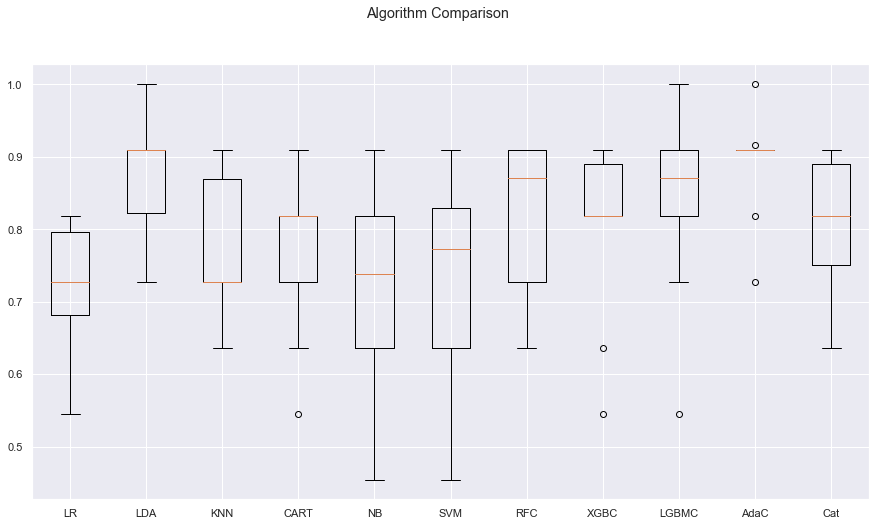

In [18]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [19]:
sex_model = AdaBoostClassifier()
sex_model.fit(train[sex_features].iloc[train['Sex'].dropna().index],train['Sex'].iloc[train['Sex'].dropna().index])
train['Sex'].iloc[np.where(train['Sex'].isnull()==True)] =  sex_model.predict(train[train['Sex'].isnull()][sex_features])
test['Sex'].iloc[np.where(test['Sex'].isnull()==True)] =  sex_model.predict(test[test['Sex'].isnull()][sex_features])

C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Delta 15 N 결측치 채우기

In [20]:
Delta_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)','Sex',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'
       ]

In [21]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.116568 (0.036340) 
LASSO : -0.238135 (0.090412) 
KNN : -0.159055 (0.078713) 
CART : -0.273602 (0.166176) 
EN : -0.211953 (0.079840) 
SVM : -0.232461 (0.090579) 
RFR : -0.152302 (0.072191) 
XGBR : -0.168228 (0.092178) 
LGBMR : -0.126749 (0.041506) 
AdaR : -0.141464 (0.064333) 
Cat : -0.152897 (0.073444) 


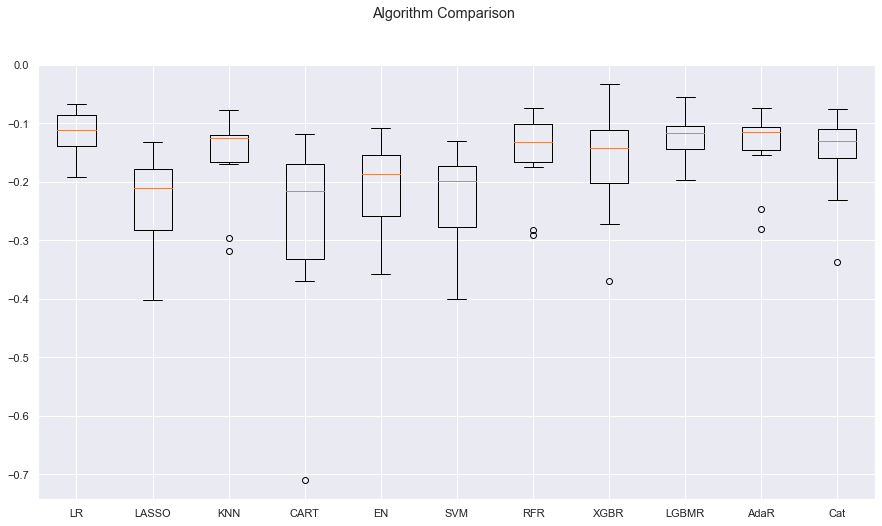

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [23]:
d15_model = AdaBoostRegressor()
d15_model.fit(train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index])
train['Delta 15 N (o/oo)'].iloc[np.where(train['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(train[train['Delta 15 N (o/oo)'].isnull()][Delta_features])
test['Delta 15 N (o/oo)'].iloc[np.where(test['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(test[test['Delta 15 N (o/oo)'].isnull()][Delta_features])

C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Delta 13 C 결측치 채우기

In [24]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.282013 (0.152863) 
LASSO : -0.478706 (0.192187) 
KNN : -0.415174 (0.254843) 
CART : -0.538642 (0.300727) 
EN : -0.396727 (0.177711) 
SVM : -0.634220 (0.269142) 
RFR : -0.346757 (0.165425) 
XGBR : -0.422721 (0.218251) 
LGBMR : -0.306097 (0.129707) 
AdaR : -0.304507 (0.137626) 
Cat : -0.398912 (0.173417) 


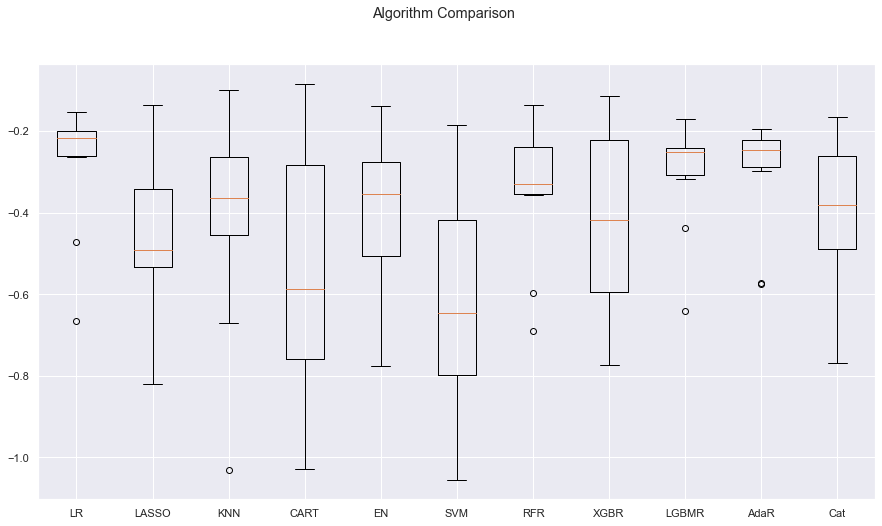

In [25]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [26]:
d13_model = LinearRegression()
d13_model.fit(train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index])
train['Delta 13 C (o/oo)'].iloc[np.where(train['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(train[train['Delta 13 C (o/oo)'].isnull()][Delta_features])
test['Delta 13 C (o/oo)'].iloc[np.where(test['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(test[test['Delta 13 C (o/oo)'].isnull()][Delta_features])

C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\wnrrh\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [27]:
for col in test.columns:
    n_nan = test[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

In [28]:
# 결측치 row 확인
train[train.isna().sum(axis=1) > 0]

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)


In [29]:
# 결측치 row 확인
test[test.isna().sum(axis=1) > 0]

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)


<AxesSubplot:title={'center':'Penguin Correlation of Features'}>

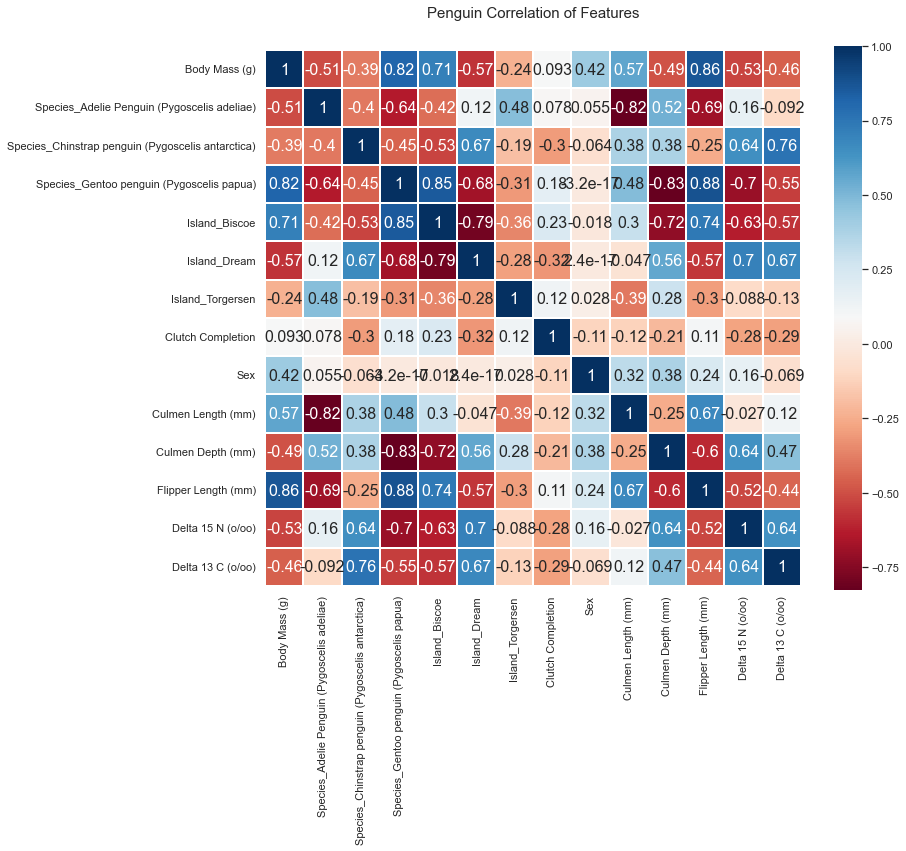

In [30]:
# 모든 변수 상관관계 분석 - 히트맵 시각화
heatmap_data = train[['Body Mass (g)','Species_Adelie Penguin (Pygoscelis adeliae)','Species_Chinstrap penguin (Pygoscelis antarctica)',
'Species_Gentoo penguin (Pygoscelis papua)','Island_Biscoe','Island_Dream','Island_Torgersen',                      
'Clutch Completion','Sex',
'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
'Delta 15 N (o/oo)','Delta 13 C (o/oo)']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(12, 10))
plt.title('Penguin Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

### 펭귄의 팔(날개)길이가 몸무게에 큰 영향을 주는 것을 발견


In [31]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


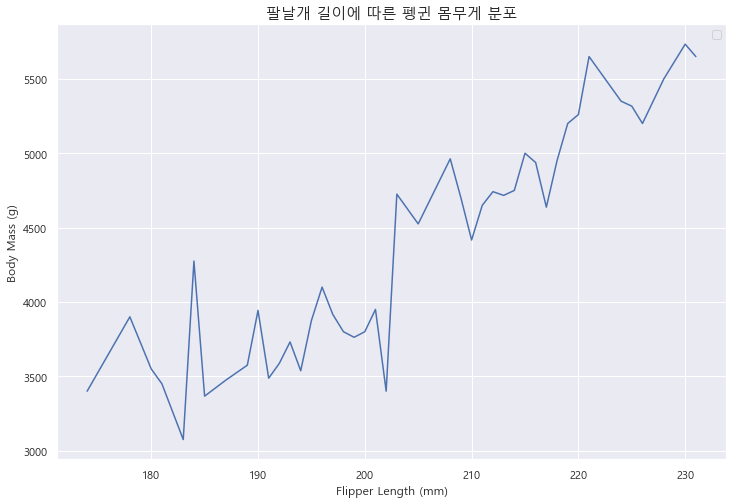

In [32]:
# 팔날개에 따른 몸무게 분포도
plt.figure(figsize=(12,8))
sns.lineplot(data=train, x='Flipper Length (mm)',y='Body Mass (g)',ci=None,label=None)
plt.title('팔날개 길이에 따른 펭귄 몸무게 분포', fontdict={'fontsize':15})
plt.legend()
plt.show()

In [33]:
train['Flipper Length (mm)'].mean()

203.05263157894737

In [34]:
# 파생변수 생성 - 팔날개 평균이상 1 평균이하 0
train['Average_length'] = train['Flipper Length (mm)'].apply(lambda x: 1 if x>=203.05263157894737 else 0)
train

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Average_length
0,1,50.0,15.3,220,1.0,8.31,-25.19,5550,1,0,0,0,0,1,1
1,0,49.5,19.0,200,1.0,9.63,-24.35,3800,0,1,0,0,1,0,0
2,1,45.1,14.4,210,0.0,8.52,-27.02,4400,1,0,0,0,0,1,1
3,1,44.5,14.7,214,0.0,8.20,-26.17,4850,1,0,0,0,0,1,1
4,0,49.6,16.0,225,1.0,8.38,-26.84,5700,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1,36.6,17.8,185,0.0,8.74,-25.94,3700,0,0,1,1,0,0,0
110,1,39.2,18.6,190,1.0,9.11,-25.80,4250,0,1,0,1,0,0,0
111,1,43.2,18.5,192,1.0,8.97,-26.04,4100,0,1,0,1,0,0,0
112,0,46.9,16.6,192,0.0,9.81,-24.74,2700,0,1,0,0,1,0,0


In [35]:
test['Flipper Length (mm)'].mean()

199.84649122807016

In [36]:
# 파생변수 생성 - 팔날개 평균이상 1 평균이하 0
test['Average_length'] = test['Flipper Length (mm)'].apply(lambda x: 1 if x>=199.84649122807016 else 0)
test

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Average_length
0,1,52.0,20.7,210.0,1.0,9.43,-24.68,0,1,0,0,1,0,1
1,1,55.9,17.0,228.0,1.0,8.31,-26.35,1,0,0,0,0,1,1
2,1,38.9,18.8,190.0,0.0,8.37,-26.11,0,1,0,1,0,0,0
3,1,45.2,16.6,191.0,0.0,9.62,-24.79,0,1,0,0,1,0,0
4,0,37.9,18.6,172.0,0.0,8.38,-25.20,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1,49.3,19.9,203.0,1.0,9.89,-24.60,0,1,0,0,1,0,1
224,1,46.5,14.8,217.0,0.0,8.58,-26.59,1,0,0,0,0,1,1
225,1,46.5,13.5,210.0,0.0,8.00,-25.33,1,0,0,0,0,1,1
226,1,50.5,19.6,201.0,1.0,9.81,-24.73,0,1,0,0,1,0,1


train = train.drop(['Flipper Length (mm)'],axis=1)
test = test.drop(['Flipper Length (mm)'],axis=1)

# data 표현

In [37]:
print(train.shape)

(114, 15)


In [38]:
print(train.dtypes)

Clutch Completion                                      int32
Culmen Length (mm)                                   float64
Culmen Depth (mm)                                    float64
Flipper Length (mm)                                    int64
Sex                                                  float64
Delta 15 N (o/oo)                                    float64
Delta 13 C (o/oo)                                    float64
Body Mass (g)                                          int64
Island_Biscoe                                          uint8
Island_Dream                                           uint8
Island_Torgersen                                       uint8
Species_Adelie Penguin (Pygoscelis adeliae)            uint8
Species_Chinstrap penguin (Pygoscelis antarctica)      uint8
Species_Gentoo penguin (Pygoscelis papua)              uint8
Average_length                                         int64
dtype: object


array([[<AxesSubplot:title={'center':'Clutch Completion'}>,
        <AxesSubplot:title={'center':'Culmen Length (mm)'}>,
        <AxesSubplot:title={'center':'Culmen Depth (mm)'}>,
        <AxesSubplot:title={'center':'Flipper Length (mm)'}>],
       [<AxesSubplot:title={'center':'Sex'}>,
        <AxesSubplot:title={'center':'Delta 15 N (o/oo)'}>,
        <AxesSubplot:title={'center':'Delta 13 C (o/oo)'}>,
        <AxesSubplot:title={'center':'Body Mass (g)'}>],
       [<AxesSubplot:title={'center':'Island_Biscoe'}>,
        <AxesSubplot:title={'center':'Island_Dream'}>,
        <AxesSubplot:title={'center':'Island_Torgersen'}>,
        <AxesSubplot:title={'center':'Species_Adelie Penguin (Pygoscelis adeliae)'}>],
       [<AxesSubplot:title={'center':'Species_Chinstrap penguin (Pygoscelis antarctica)'}>,
        <AxesSubplot:title={'center':'Species_Gentoo penguin (Pygoscelis papua)'}>,
        <AxesSubplot:title={'center':'Average_length'}>, <AxesSubplot:>]],
      dtype=object)

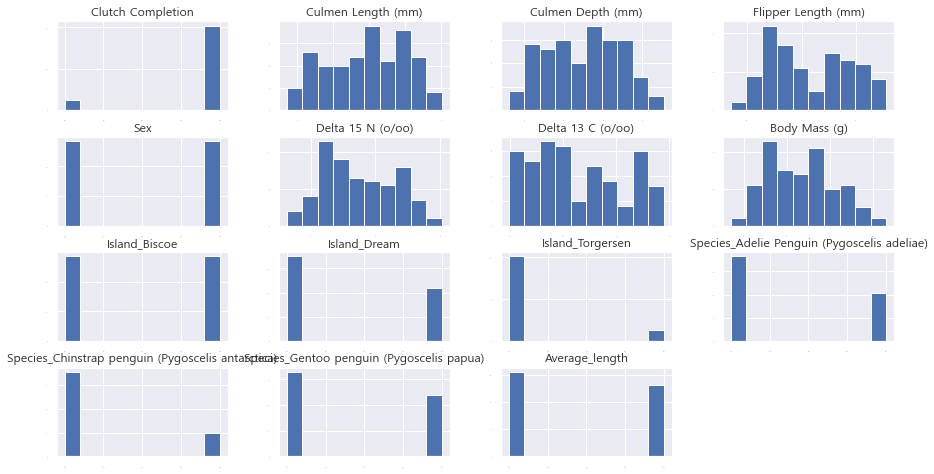

In [39]:
# train 데이터 히스토그램
train.hist(sharex=False,sharey=False,xlabelsize = 1,ylabelsize=1)

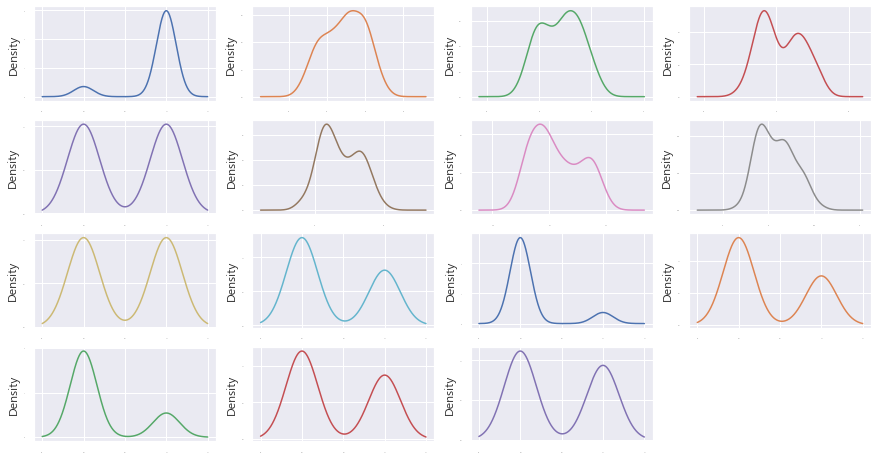

In [40]:
# density plot으로 표현
train.plot(kind='density',subplots = True,layout = (4,4),sharex=False,sharey=False,legend=False,fontsize=1)
plt.show()

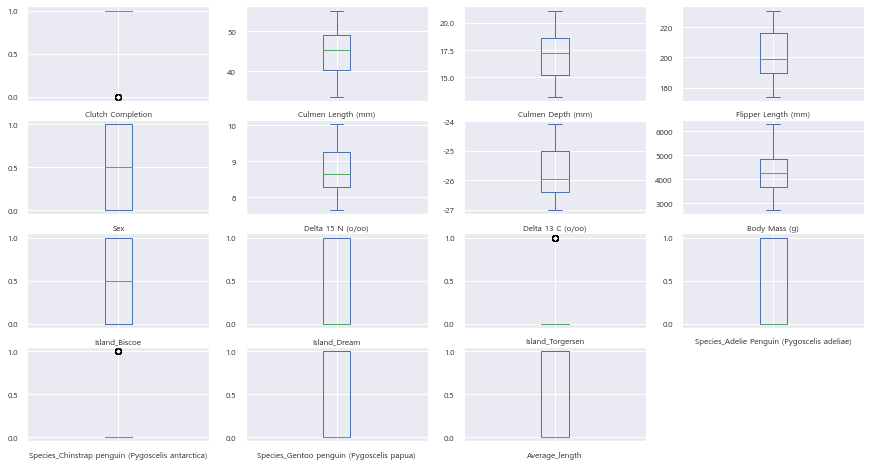

In [41]:
# box plot 으로 표현
train.plot(kind='box',subplots=True,layout=(4,4),sharex=False,sharey=False,legend=False,fontsize=8)
plt.show()

In [42]:
# 알고리즘 평가
train.columns

Index(['Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Average_length'],
      dtype='object')

In [43]:
num_folds= 10
seed = 7
scoring = 'neg_root_mean_squared_error'

In [44]:
X_all = train[test.columns.tolist()]
y_all = train['Body Mass (g)']

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(train[test.columns.tolist()],train['Body Mass (g)']
                                                      ,test_size=0.2,random_state=seed)

In [46]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor()))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(verbose=False)))
models.append(('Xtree',ExtraTreesRegressor()))

results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -333.409182 (59.902988) 
LASSO : -331.603608 (58.396634) 
KNN : -388.766440 (54.708975) 
CART : -408.854905 (85.599357) 
EN : -374.964852 (58.327863) 
SVM : -775.633572 (193.159544) 
RFR : -337.107768 (83.921267) 
XGBR : -368.253428 (64.055256) 
LGBMR : -343.871837 (57.176551) 
AdaR : -344.427675 (63.362256) 
Cat : -321.961918 (80.715031) 
Xtree : -325.862657 (77.207060) 


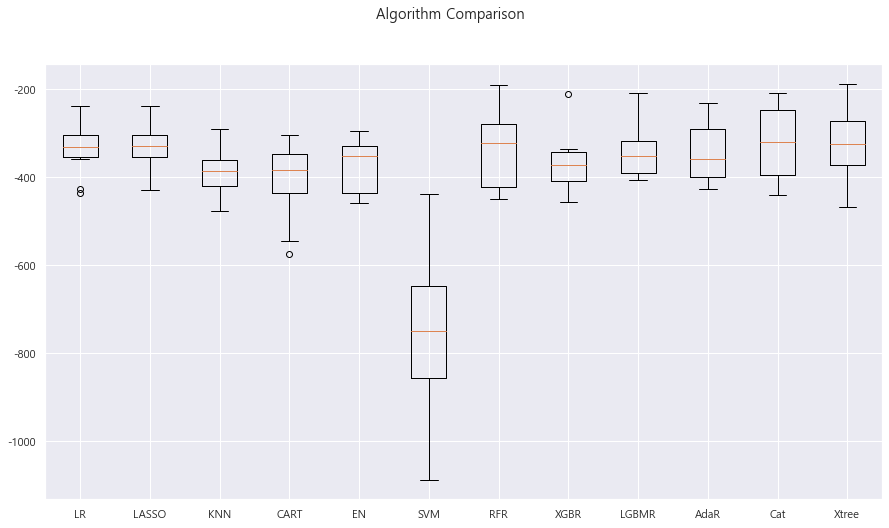

In [47]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [48]:
# 표준화
pipelines = []
pipelines.append(('ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('SVM',SVR())])))
pipelines.append(('ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('RFR',RandomForestRegressor())])))
pipelines.append(('ScaledXGBR',Pipeline([('Scaler',preprocessing.StandardScaler()),('XGBR',XGBRegressor())])))
pipelines.append(('ScaledLGBMR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LGBMR',LGBMRegressor())])))
pipelines.append(('ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('ScaledCat',Pipeline([('Scaler',preprocessing.StandardScaler()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('Xtree',ExtraTreesRegressor())])))

results_scaled =[]
names_scaled = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_scaled.append(cv_results)
  names_scaled.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

ScaledLR : -333.409182 (59.902988) 
ScaledLASSO : -332.891693 (58.443418) 
ScaledKNN : -341.724895 (68.397829) 
ScaledCART : -402.181306 (91.962716) 
ScaledEN : -338.532545 (59.163922) 
ScaledSVM : -766.913875 (192.187040) 
ScaledRFR : -341.497794 (82.324726) 
ScaledXGBR : -368.586736 (64.295311) 
ScaledLGBMR : -346.671813 (60.499682) 
ScaledAdaR : -358.439750 (57.832599) 
ScaledCat : -322.998895 (78.747428) 
ScaledXtree : -325.403678 (72.825038) 


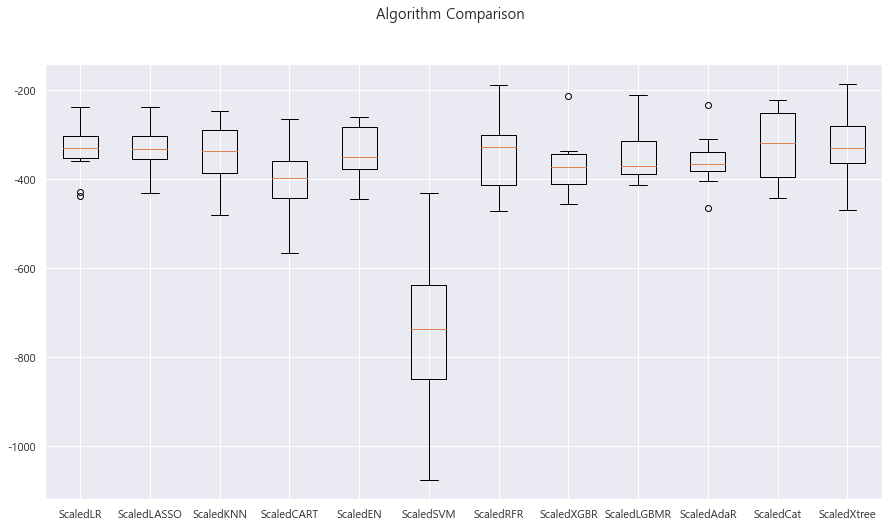

In [49]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

In [50]:
# 정규화
pipelines = []
pipelines.append(('NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('LR',LinearRegression())])))
pipelines.append(('NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('LASSO',Lasso())])))
pipelines.append(('NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('KNN',KNeighborsRegressor())])))
pipelines.append(('NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('CART',DecisionTreeRegressor())])))
pipelines.append(('NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('EN',ElasticNet())])))
pipelines.append(('NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('SVM',SVR())])))
pipelines.append(('NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('RFR',RandomForestRegressor())])))
pipelines.append(('NormXGBR',Pipeline([('Scaler',preprocessing.Normalizer()),('XGBR',XGBRegressor())])))
pipelines.append(('NormLGBMR',Pipeline([('Scaler',preprocessing.Normalizer()),('LGBMR',LGBMRegressor())])))
pipelines.append(('NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('NormCat',Pipeline([('Scaler',preprocessing.Normalizer()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('Xtree',ExtraTreesRegressor())])))

results_norm =[]
names_norm = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_norm.append(cv_results)
  names_norm.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

NormLR : -341.174874 (57.313595) 
NormLASSO : -535.723505 (76.352728) 
NormKNN : -384.565981 (42.631567) 
NormCART : -373.359556 (118.859759) 
NormEN : -771.841055 (171.084425) 
NormSVM : -776.124756 (193.274382) 
NormRFR : -345.829184 (90.906976) 
NormXGBR : -326.775960 (58.294874) 
NormLGBMR : -339.155474 (89.009178) 
NormAdaR : -361.604120 (92.791372) 
NormCat : -346.235336 (76.914625) 
NormXtree : -340.507139 (59.979492) 


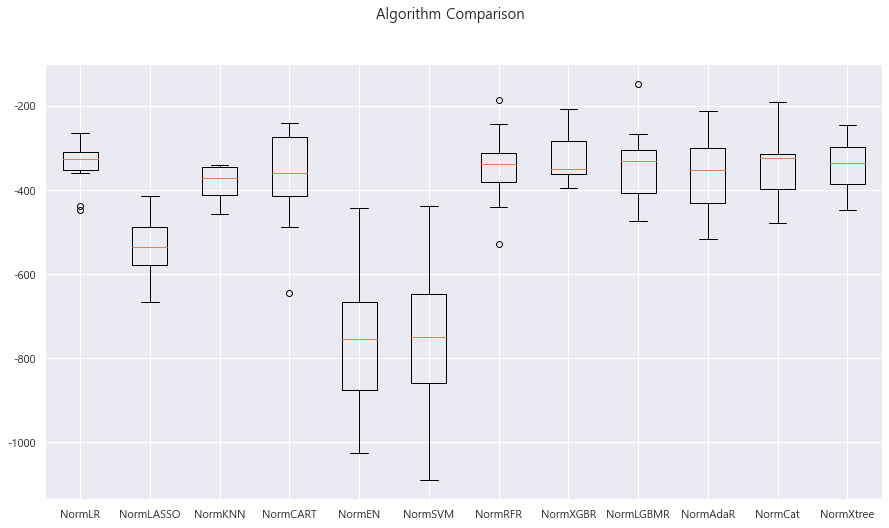

In [51]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_norm)
ax.set_xticklabels(names_norm)
plt.show()

In [52]:
# scaled 알고리즘 비교
# 평균값 비교
compare_algo_mean = pd.DataFrame([ i.mean() for i in results],columns=['Base'],index=names)
compare_algo_mean['Stand'] = [ i.mean() for i in results_scaled]
compare_algo_mean['Norm'] = [ i.mean() for i in results_norm]

<Figure size 1152x576 with 0 Axes>

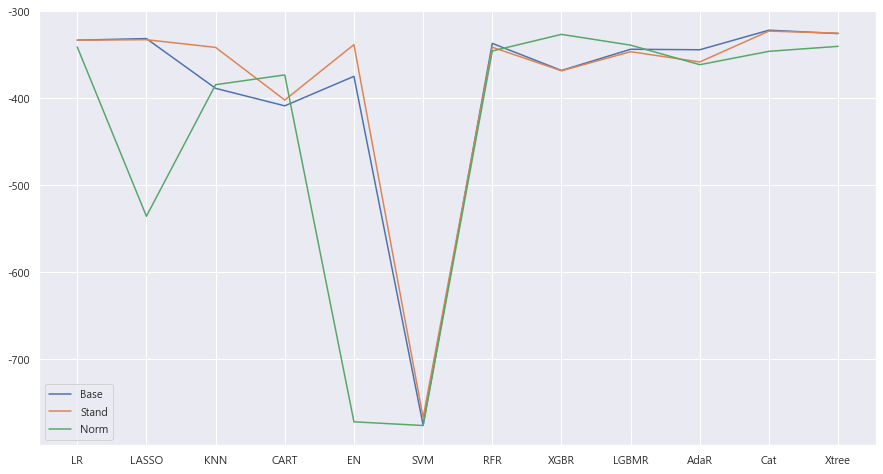

In [53]:
plt.figure(figsize=(16,8))
ax = compare_algo_mean.plot()
plt.xticks(range(len(compare_algo_mean.index)), compare_algo_mean.index)
plt.show()

In [54]:
# 중간값 비교
compare_algo_mid = pd.DataFrame([ np.median(i) for i in results],columns=['Base'],index=names)
compare_algo_mid['Stand'] = [ np.median(i)for i in results_scaled]
compare_algo_mid['Norm'] = [ np.median(i) for i in results_norm]

<Figure size 1152x576 with 0 Axes>

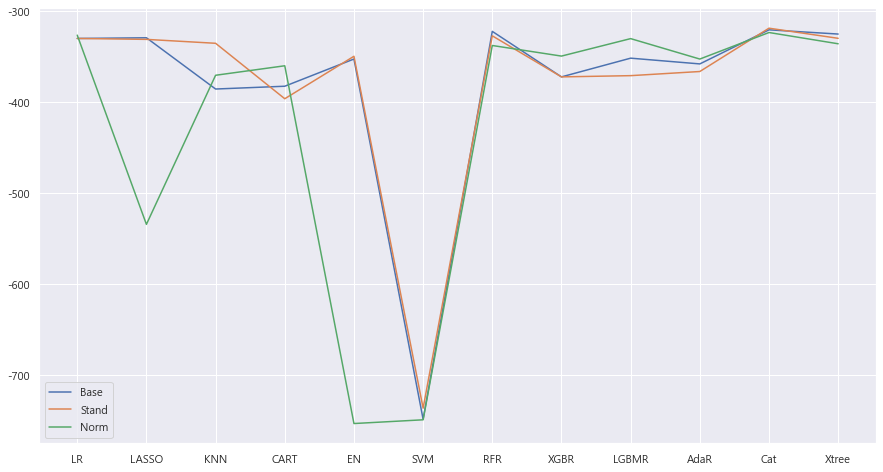

In [55]:
plt.figure(figsize=(16,8))
ax =compare_algo_mid.plot()
plt.xticks(range(len(compare_algo_mid.index)), compare_algo_mid.index)
plt.show()

# data scaling

In [56]:
scaler = preprocessing.StandardScaler().fit(X_all)
scaled_X = scaler.transform(X_all)
normalizer = preprocessing.Normalizer().fit(X_all)
normalized_X = normalizer.transform(X_all)

# RandomForest Tuning

In [57]:
# hyperparameter 튜닝

params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6,12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2, 8, 16, 20]
            }
model = RandomForestRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all, y_all)

In [58]:
print("Best : %f using %s "%((-(grid_result.best_score_)),grid_result.best_params_))

Best : 323.594286 using {'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 10} 


# Extra Tree Tuning

In [59]:
params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6,12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2,4,8, 16]
            }
model =ExtraTreesRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)

In [60]:
print("Best : %f using %s "%((-(grid_result.best_score_)),grid_result.best_params_))

Best : 312.190795 using {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 10} 


# 앙상블

In [77]:
# Ensemble
from sklearn.metrics import mean_squared_error
import math 

errors = []
pred_valid=[]
pred_test = []
scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(test)
normalizer = preprocessing.Normalizer().fit(X_train)
normalized_X_train = normalizer.transform(X_train)
normalized_X_valid = normalizer.transform(X_valid)
normalized_X_test = normalizer.transform(test)

ScaledCat : -315.346995 (89.698141) 
ScaledRFR : -317.869524 (78.498718)  
ScaledLGBMR : -321.730254 (74.183486) 
NormCat : -294.842873 (70.026250) 
scaled한 RF, Normalization한 Catboost와 LGBMR 일반 베이스의 Xtree 

# Scaled LGBMRegressor 튜닝

lgbm = LGBMRegressor(random_state=seed)
lgbm.fit(scaled_X_train, y_train)
lgbm_valid = lgbm.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lgbm_valid))
errors.append(('lgbm',rmse))
pred_valid.append(('lgbm',lgbm_valid))
lgbm_test = lgbm.predict(scaled_X_test)
pred_test.append(('lgbm',lgbm_test))

# Lasso

In [78]:
lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_valid = lasso.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lasso_valid))
errors.append(('Lasso',rmse))
pred_valid.append(('Lasso',lasso_valid))
lasso_test = lasso.predict(test)
pred_test.append(('Lasso',lasso_test))

# scaled LR

In [79]:
LR = LinearRegression()
LR.fit(scaled_X_train,y_train)
lr_valid = LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lr_valid))
errors.append(('LR',rmse))
pred_valid.append(('LR',lr_valid))
lr_test = LR.predict(scaled_X_test)
pred_test.append(('LR',lr_test))

# RF

In [80]:
RF =RandomForestRegressor(max_depth=6, min_samples_leaf= 12, min_samples_split= 2, n_estimators=10)
RF.fit(X_train,y_train)
rf_valid = RF.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, rf_valid))
errors.append(('RF',rmse))
pred_valid.append(('RF',rf_valid))
rf_test = RF.predict(scaled_X_test)
pred_test.append(('RF',rf_test))

C:\Users\wnrrh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Extra Tree

In [81]:
ET = ExtraTreesRegressor(max_depth=6, min_samples_leaf= 1, min_samples_split= 16, n_estimators= 10)
ET.fit(X_train,y_train)
et_valid = ET.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, et_valid))
errors.append(('ET',rmse))
pred_valid.append(('ET',et_valid))
et_test = ET.predict(test)
pred_test.append(('ET',et_test))

# Normalized CatBoost

In [82]:
CAT = CatBoostRegressor(iterations=10000,random_state=7 
           ,eval_metric="RMSE")
CAT.fit(X_train,y_train, eval_set=[(X_valid,y_valid)],early_stopping_rounds=300
        ,verbose=1000 )
cat_valid = CAT.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, cat_valid))
errors.append(('CAT',rmse))
pred_valid.append(('CAT',cat_valid))
cat_test = CAT.predict(test)
pred_test.append(('CAT',cat_test))

Learning rate set to 0.00858
0:	learn: 773.2084278	test: 779.6331158	best: 779.6331158 (0)	total: 1.11ms	remaining: 11.1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 314.9308032
bestIteration = 699

Shrink model to first 700 iterations.


In [83]:
for name, error in errors:
  print("{} : {}".format(name,error))

Lasso : 288.8799206535807
LR : 292.81120304743774
RF : 356.6489282541837
ET : 278.3148631372699
CAT : 314.93080318850184


In [84]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  val+= (0.2 * pred)
math.sqrt(mean_squared_error(y_valid, val))

289.41631541335863

In [89]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  if name=='ET':
    val+=  (pred)
math.sqrt(mean_squared_error(y_valid, val))

278.3148631372699

In [85]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name == 'CAT':
    val+= (0.25 * pred)
math.sqrt(mean_squared_error(y_valid, val))

281.3292029862633

In [86]:
test_val= np.zeros(test.shape[0])
for name, pred in pred_test:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name=='CAT':
    test_val+= (0.25 * pred)

In [ ]:
test_val= np.zeros(test.shape[0])
for name, pred in pred_test:
  if name == 'Lasso' or name=='LR' or name == 'ET':
    test_val+= (0.33* pred)

In [91]:
ss['Body Mass (g)'] = test_val

,id,Body Mass (g)
0,0,4222.14
1,1,5514.83
2,2,3494.05
3,3,3626.15
4,4,3227.68
...,...,...
223,223,4156.31
224,224,4784.77
225,225,4534.89
226,226,4054.69


In [5]:
ss

,id,Body Mass (g)
0,0,4168.630110
1,1,5578.617692
2,2,3567.594506
3,3,3354.083682
4,4,3386.624223
...,...,...
223,223,3933.841555
224,224,4736.054042
225,225,4633.511181
226,226,3905.891657


In [92]:
ss.to_csv('C:/Users/wnrrh/desktop/dacon/penguin/4model_ss.csv',index=False)